# Depth anything - HuggingFace 🤗

In [ ]:
from transformers import pipeline, YolosConfig, YolosModel
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import ipywidgets as widgets
from tempfile import NamedTemporaryFile
from pathlib import Path

configuration = YolosConfig()
model = YolosModel(configuration)
configuration = model.config


image = cv2.cvtColor(cv2.imread("../assets/sel&poivre.jpg"), cv2.COLOR_BGR2RGB)
# Setup the pipeline
depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
depth = np.array(depth_estimator(Image.fromarray(image))["depth"])

obj_detector = pipeline("object-detection", model="hustvl/yolos-tiny")
bounding_boxes = obj_detector(Image.fromarray(image))

for bounding_box in bounding_boxes:
    box = bounding_box["box"]
    label = bounding_box["label"]
    score = bounding_box["score"]
    # draw bounding box, label and score on image from opencv
    x1 = box["xmin"] 
    y1 = box["ymin"] 
    x2 = box["xmax"] 
    y2 = box["ymax"]
    image = cv2.rectangle(image, (x1,y1), (x2, y2), (255, 0, 0), 2)
    image = cv2.putText(image, f"{label} {score:.2f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].imshow(depth, cmap='inferno')
axes[0].set_title('Original Depth Mask')
axes[1].imshow(image)
axes[1].set_title('Object Detection')
plt.show()

## YoloV8 + Depth pipeline

Params passed to Resize transform:
	width:  518
	height:  392
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  14
	resize_method:  minimal
Using pretrained resource local::./checkpoints/depth_anything_metric_depth_indoor.pt
Loaded successfully

0: 512x640 1 person, 6 chairs, 2 dining tables, 3 tvs, 53.0ms
Speed: 1.5ms preprocess, 53.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


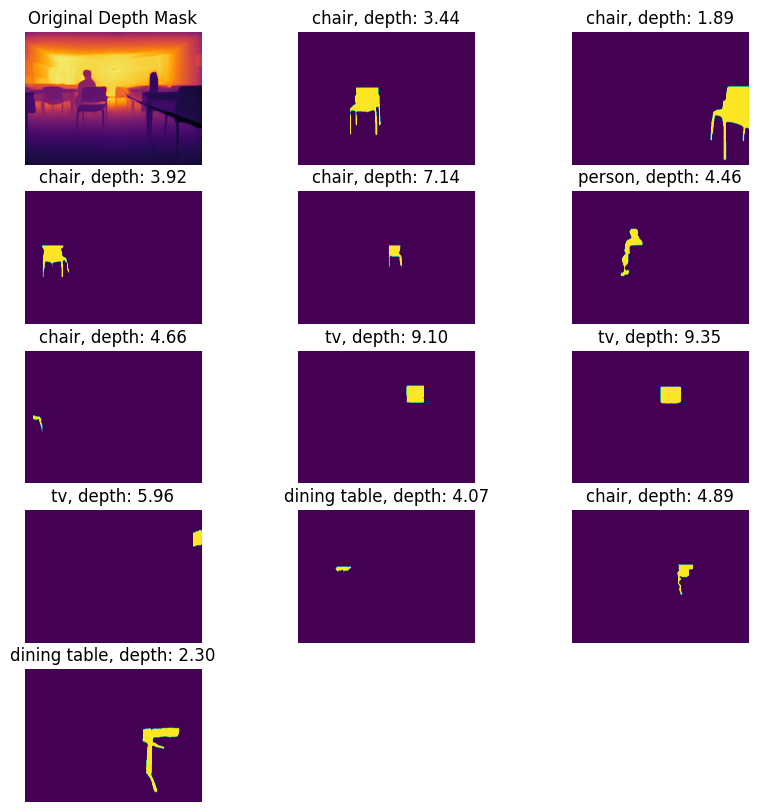

In [10]:
import torch
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from transformers import pipeline
from PIL import Image
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config

# ZoeD_N
conf = get_config("zoedepth", "eval", 'nyu')

conf.pretrained_resource = "local::./checkpoints/depth_anything_metric_depth_indoor.pt"
model_zoe_n = build_model(conf)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe = model_zoe_n.to(DEVICE)


yolo_segmentation = YOLO('yolov8x-seg.pt')
img = cv2.cvtColor(cv2.imread("../assets/calib_6.jpg"), cv2.COLOR_BGR2RGB)


depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
depth = zoe.infer_pil(Image.fromarray(img))  
#depth = np.array(depth_estimator(Image.fromarray(img))["depth"])


results = yolo_segmentation(source=img.copy())
for result in results:
    masks = result.masks
    resulting_masks = []
    classes = [result.names[id] for id in result.boxes.cls.tolist()]
    
    for c, mask_data in zip(classes, masks):
        mask = np.zeros(img.shape[:2], np.uint8)
        contour = mask_data.xy.pop().astype(np.int32)
        contour = contour.reshape(-1, 1, 2)

        _ = cv2.drawContours(mask, [contour], -1, (255,255,255), cv2.FILLED)
        resulting_masks.append((c, mask))

# Plot the resulting masks
num_masks = len(resulting_masks)
num_rows = ((num_masks + 1) // 3) +1

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 10))

axes[0, 0].imshow(depth, cmap='inferno')
axes[0, 0].set_title('Original Depth Mask')
axes[0, 0].axis('off')

for i, (c, mask) in enumerate(resulting_masks):
    row = (i + 1) // 3
    col = (i + 1) % 3
    axes[row, col].imshow(mask, alpha=1)
    mean_depth = np.median(depth[mask > 0])
    axes[row, col].set_title(f'{c}, depth: {mean_depth:.2f}')
    axes[row, col].axis('off')

# Remove empty subplots
for i in range(num_masks + 1, num_rows * 3):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

    

plt.show()

# ZoeDepth

In [ ]:
import torch
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
import cv2
from matplotlib import pyplot as plt
import numpy as np
from transformers import pipeline
from PIL import Image

# Zoe_N
#model_zoe_n = torch.hub.load("isl-org/ZoeDepth", "ZoeD_N", pretrained=True)
#model_zoe_n = torch.hub.load(".", "ZoeD_N", source="local", pretrained=True)



# ZoeD_N
conf = get_config("zoedepth", "eval", 'nyu')
#conf = edict({'pretrained_resource': None, 'dataset': 'nyu', 'avoid_boundary': False, 'min_depth': 0.001, 'max_depth': 10, 'data_path': './data/nyu', 'gt_path': './data/nyu', 'filenames_file': './train_test_inputs/nyudepthv2_train_files_with_gt.txt', 'input_height': 480, 'input_width': 640, 'data_path_eval': './data/nyu', 'gt_path_eval': './data/nyu', 'filenames_file_eval': './train_test_inputs/nyudepthv2_test_files_with_gt.txt', 'min_depth_eval': 0.001, 'max_depth_eval': 10, 'min_depth_diff': -10, 'max_depth_diff': 10, 'do_random_rotate': True, 'degree': 1.0, 'do_kb_crop': False, 'garg_crop': False, 'eigen_crop': True, 'save_dir': './depth_anything_finetune', 'project': 'ZoeDepth', 'tags': '', 'notes': '', 'gpu': None, 'root': '.', 'uid': None, 'print_losses': False, 'distributed': True, 'workers': 16, 'clip_grad': 0.1, 'use_shared_dict': False, 'shared_dict': None, 'use_amp': False, 'aug': True, 'random_crop': False, 'random_translate': False, 'translate_prob': 0.2, 'max_translation': 100, 'validate_every': 0.25, 'log_images_every': 0.1, 'prefetch': False, 'name': 'ZoeDepth', 'version_name': 'v1', 'n_bins': 64, 'bin_embedding_dim': 128, 'bin_centers_type': 'softplus', 'n_attractors': [16, 8, 4, 1], 'attractor_alpha': 1000, 'attractor_gamma': 2, 'attractor_kind': 'mean', 'attractor_type': 'inv', 'midas_model_type': 'DPT_BEiT_L_384', 'min_temp': 0.0212, 'max_temp': 50.0, 'output_distribution': 'logbinomial', 'memory_efficient': True, 'inverse_midas': False, 'img_size': [392, 518], 'train_midas': False, 'use_pretrained_midas': False, 'pretrained_resource': 'local::../assets/depth_anything_metric_depth_indoor.pt', 'model': 'zoedepth'})
conf.pretrained_resource = "local::./checkpoints/depth_anything_metric_depth_indoor.pt"
model_zoe_n = build_model(conf)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe = model_zoe_n.to(DEVICE)


img = cv2.cvtColor(cv2.imread("../assets/calib_1.jpg"), cv2.COLOR_BGR2RGB)
depth_numpy = zoe.infer_pil(Image.fromarray(img))  
plt.imshow(depth_numpy, cmap='inferno')
plt.show()


#0
Focal Lengths: 592.9954375798122, 587.0366713613253
Optical Centers: 335.4815797115062, 223.10928966594665
#1
Focal Lengths: 1261.20836649568, 823.1253179650824
Optical Centers: 284.0352376104085, 276.12250719098876
#2
Focal Lengths: 618.343854663624, 616.4500646561445
Optical Centers: 318.6889430166586, 224.99605535584578